In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier

In [2]:
takehome_users = pd.read_csv('takehome_users.csv', 
                             encoding = "ISO-8859-1",
                             parse_dates=['creation_time'],
                             dtype={'opted_in_to_mailing_list': np.bool, 
                                    'enabled_for_marketing_drip': np.bool})
takehome_users['last_session_creation_time'] = pd.to_datetime(takehome_users['last_session_creation_time'], unit='s')
takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,True,False,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,False,False,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,False,False,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,False,False,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,False,False,193,5240.0


In [3]:
takehome_user_engagement = pd.read_csv('takehome_user_engagement.csv', 
                                       encoding = "ISO-8859-1", 
                                       parse_dates=['time_stamp'], 
                                       index_col='time_stamp')
takehome_user_engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [4]:
# visits in 7 day range
weekly = takehome_user_engagement.groupby('user_id')\
                                .rolling(window='7D')['visited']\
                                .count()\
                                .reset_index() 

# list of 'adopted' users
adopted_users = weekly[weekly['visited'] > 2]['user_id'].unique()

# flag 'adopted' in dataframe (and convert to 1's and 0's)
takehome_users['adopted'] = takehome_users['object_id'].isin(adopted_users).astype(np.bool)

## Which factors predict future user adoption?

In [5]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null bool
enabled_for_marketing_drip    12000 non-null bool
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null bool
dtypes: bool(3), datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 785.2+ KB


`<invited_by_user_id>` should be converted to *int64* (same as `<obj_id>`):

In [6]:
takehome_users.invited_by_user_id = takehome_users.invited_by_user_id.fillna(0).astype(np.int64)
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null bool
enabled_for_marketing_drip    12000 non-null bool
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null int64
adopted                       12000 non-null bool
dtypes: bool(3), datetime64[ns](2), int64(3), object(3)
memory usage: 785.2+ KB


`<object_id>` and `<name>` are individual to each user and therefore unlikely to be meaningful predictors. Theoretically it would be possible to analyze names for probability of gender, age, race or nationality, but given the limited scope of this project we'll skip that.

In [7]:
# count adopted users 'True'
takehome_users.groupby('adopted')['adopted'].count()

adopted
False    10398
True      1602
Name: adopted, dtype: int64

In [8]:
# adoption rate
adoption_rate = takehome_users['adopted'].mean() * 100
print('{:.2f}% of users are considered "adopted".'.format(adoption_rate))

13.35% of users are considered "adopted".


### Creation time

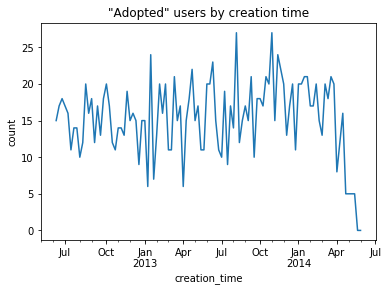

In [9]:
takehome_users.set_index('creation_time').resample('W')['adopted'].sum()[1:].plot() # ignore incomplete first week
plt.title('"Adopted" users by creation time')
plt.ylabel('count')
plt.show()

No obvious trends can be seen plotting the number of ***adopted*** users by their creation time. Similarly, there is no significant relationship to day of the week, as shown below. 

The sharp dropoff in April or May 2014 indicates fresh users haven't had enough time to become "adopted". This data should be discarded since it would not be helpful in long-term prediction.

In [10]:
# trim most recent data
takehome_users = takehome_users.loc[takehome_users.creation_time < '2014-04-20']

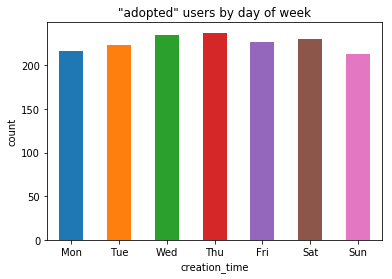

In [11]:
creation = takehome_users.set_index('creation_time')
ax = creation.groupby(creation.index.dayofweek).sum()['adopted'].plot.bar(rot=0)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_title('"adopted" users by day of week')
plt.ylabel('count')
plt.show()

### Email domain

In [12]:
takehome_users['domain'] = takehome_users.apply(lambda x: x['email'].split('@')[-1].split('.')[0], axis=1)
takehome_users['domain'].value_counts()[:15]

gmail         3189
yahoo         2170
jourrapide    1140
cuvox         1097
gustr         1056
hotmail       1026
mumdc            2
oqpze            2
luque            2
rerwl            2
qgjbc            2
xybhi            2
xvnbr            2
dqwln            2
mppgi            1
Name: domain, dtype: int64

Most users belong to one of six email providers. There are still over 1000 emails that have clearly been anonymized. We'll group them together as "other".

In [13]:
# merge "other" providers
top_providers = takehome_users['domain'].value_counts()[:6].index
takehome_users['domain'] = takehome_users.apply(lambda x: x['domain'] if x['domain'] in top_providers else 'other' , axis=1)

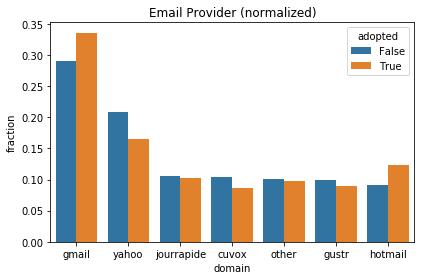

In [14]:
# plot feature distribution
feature = 'domain'
df = (takehome_users
      .groupby('adopted')[feature]
      .value_counts(normalize=True)
      .rename('fraction')
      .reset_index())

sns.barplot(x=feature, y='fraction', hue='adopted', data=df)
plt.xticks(rotation=0)
plt.title('Email Provider (normalized)')
plt.tight_layout()
plt.show()

**Gmail** and **hotmail** users are slightly more likely to become adopted.

### Creation source

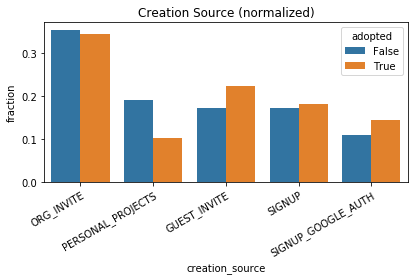

In [15]:
feature = 'creation_source'
df = (takehome_users
      .groupby('adopted')[feature]
      .value_counts(normalize=True)
      .rename('fraction')
      .reset_index())

sns.barplot(x=feature, y='fraction', hue='adopted', data=df)
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
plt.title('Creation Source (normalized)')
plt.tight_layout()
plt.show()

Finally, `creation_source` appears to be a factor in determining if a user is adopted, in particular users with category ***PERSONAL_PROJECTS*** are less likely to become adopted.

### Last session creation time

About one quarter of users have missing values for this feature. Does that mean they haven't logged in since the initial signup? This could possibly be inferred from the engagement data, but it seems beyond the scope of identifying important indicators within "1-2 hours".

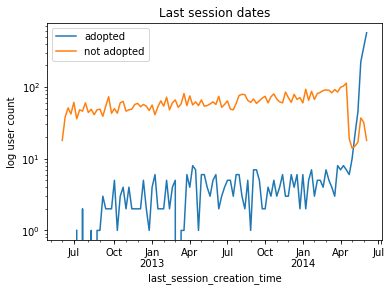

In [16]:
last_session = takehome_users.set_index('last_session_creation_time')
last_session[last_session.adopted == 1].resample('W').count()['adopted'].plot(logy=True)
last_session[last_session.adopted == 0].resample('W').count()['adopted'].plot(logy=True)
plt.title('Last session dates')
plt.ylabel('log user count')
plt.legend(['adopted', 'not adopted'])
plt.show()

Over time there is a steady dropout of non-adopted users, and to a lesser extent adopted users. The majority of adopted users have recently created a session. The most recent month or two of not adopted data shows low session creation numbers because the creation time has been limited to before April 20.

In [17]:
sessions2013 = last_session['2013-01-01':'2014-01-01']['adopted']
sessions2013_rate = sessions2013.sum() / sessions2013.count() * 100

print('{:.2f}% of users with a last session in 2013 are adopted compared to {:.2f}% overall'.format(sessions2013_rate, adoption_rate))

5.96% of users with a last session in 2013 are adopted compared to 13.35% overall


`<last_session_creation_time>` is a strong indicator for adopted users. The majority of adopted users have recently created a session. We'll create a Boolean feature with a somewhat arbitrary cutoff date:

In [18]:
takehome_users['last_session_in_2013'] = takehome_users.apply(lambda y: True if y['last_session_creation_time'] < pd.to_datetime('2014-01-01') else False, axis=1)

### Opted in to mailing list

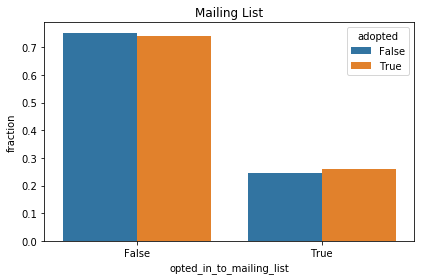

In [19]:
feature = 'opted_in_to_mailing_list'
df = (takehome_users
      .groupby('adopted')[feature]
      .value_counts(normalize=True)
      .rename('fraction')
      .reset_index())

sns.barplot(x=feature, y='fraction', hue='adopted', data=df)
plt.xticks(rotation=0)
plt.title('Mailing List')
plt.tight_layout()
plt.show()

### Enabled for marketing drip

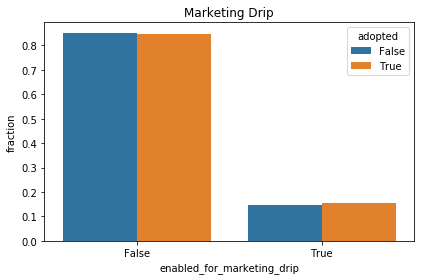

In [20]:
feature = 'enabled_for_marketing_drip'
df = (takehome_users
      .groupby('adopted')[feature]
      .value_counts(normalize=True)
      .rename('fraction')
      .reset_index())

sns.barplot(x=feature, y='fraction', hue='adopted', data=df)
plt.xticks(rotation=0)
plt.title('Marketing Drip')
plt.tight_layout()
plt.show()



On the other hand, percentage of users `<enabled_for_marketing_drip>` is close to the percentage of adopted users.

### Org_id

In [21]:
# Number of organizations
len(takehome_users.org_id.unique())

417

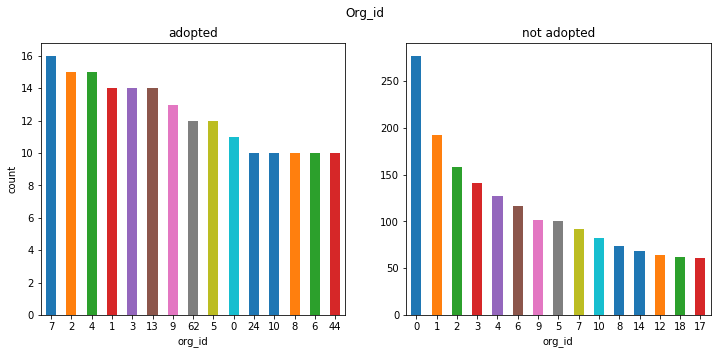

In [22]:
# plot most common organizations by adopted status
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
takehome_users[takehome_users.adopted == True].groupby('org_id')['adopted'].count().sort_values(ascending=False)[:15].plot.bar(rot=0, ax=ax1)
takehome_users[takehome_users.adopted == False].groupby('org_id')['adopted'].count().sort_values(ascending=False)[:15].plot.bar(rot=0, ax=ax2)
ax1.set_title('adopted')
ax2.set_title('not adopted')
plt.suptitle('Org_id')
ax1.set_ylabel('count')
plt.show()

Users belong to one of 417 organizations. Since there is no missing data in this column, perhaps organization `0` is code for not belonging to any other organization?

Organization `<7>` tends to have more adopted members than average and organization `<0>` more non-adopted members than any other group. Relative to the size of the users and the total number of organizations, this appears to be a weak predictor, nonetheless, it's easy to create a feature based on organization membership, which would turn a categorical feature into a numeric one:

In [23]:
# create column with membership size of organization
org_size = takehome_users['org_id'].value_counts()
takehome_users['org_size'] = takehome_users['org_id'].map(org_size)

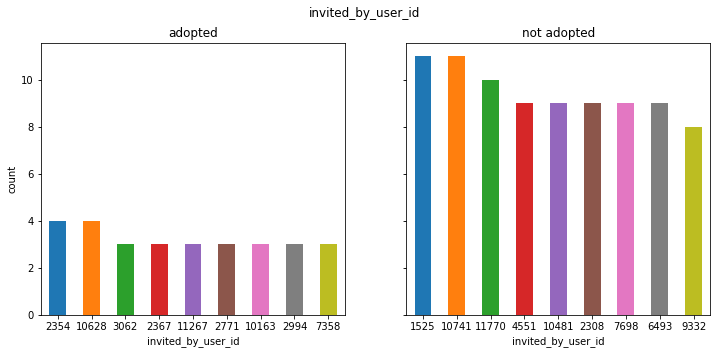

In [24]:
# plot top users invited by another user
# starting at index=1 to ignore not invited users

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5), sharey=True)
takehome_users[takehome_users.adopted == 1]\
            .groupby('invited_by_user_id')['adopted']\
            .count().sort_values(ascending=False)[1:10]\
            .plot.bar(rot=0, ax=ax1)
takehome_users[takehome_users.adopted == 0]\
            .groupby('invited_by_user_id')['adopted']\
            .count().sort_values(ascending=False)[1:10]\
            .plot.bar(rot=0, ax=ax2)
ax1.set_title('adopted')
ax2.set_title('not adopted')
plt.suptitle('invited_by_user_id')
ax1.set_ylabel('count')
plt.show()

It would be possible to map significant "influencers" who invited more users than others. For simplicity we'll just flag whether or not a user was invited.

In [25]:
# flag whether a user was invited by another
takehome_users['invited'] = takehome_users['invited_by_user_id'] > 0
invited = takehome_users.invited.mean() * 100
print('{:.2f}% of users were invited by another user.'.format(invited))

53.29% of users were invited by another user.


## Other features

As the objective is to not spend too much time on this project, some possible additional features will be ignored. For example, time stamps could be mined for features such as login times or `<invited_by_user_id>`'s could be converted to categorical values.

## Automatic feature selection with decision trees

Feature importance is a by product of the decision tree algorithm. There is an added benefit in that decision trees are less sensitive to class imbalance.

In [26]:
# prepare categorical features. 

X = takehome_users.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 
                         'org_id', 'invited_by_user_id', 'adopted'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = takehome_users.adopted

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=26)

forest.fit(X, y)

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

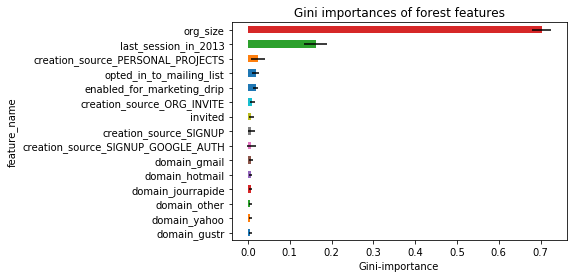

In [27]:
# plot feature importances

features = pd.DataFrame({'feature_name': X.columns, 'importance': forest.feature_importances_, 'std': std})
features.sort_values('importance')\
        .plot.barh(x='feature_name', y='importance', xerr='std', legend=False)
plt.title('Gini importances of forest features')
plt.xlabel('Gini-importance')
plt.show()

As noted earlier, some features were arbitrarily excluded from evaluation. Of the features selected for analysis, the decision tree "Gini-impurity" algorithm determined a list of importances. The three main predictors for a user to become ***adopted*** are the size of the organization they belong to, whether or not they logged in within the last 6 months, and whether they were referred by ***personal_projects***. 